In [1]:
import datetime as dt
import os
import sys
sys.path.append(os.pardir)
from math import ceil

import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates

from coropy.utils import moving_average
from coropy import reproduction_rate

In [2]:
# data
DATA_PATH = os.path.join(os.pardir, 'data')
COUNTRY = 'CRO'
DATA = os.path.join(DATA_PATH, COUNTRY)
CONFIRMED_CASES_PATH = os.path.join(
    DATA_PATH, COUNTRY, 'confirmed_cases.dat')
RECOVERED_CASES_PATH = os.path.join(
    DATA_PATH, COUNTRY, 'recovered_cases.dat')
DEATH_CASES_PATH = os.path.join(
    DATA_PATH, COUNTRY, 'death_cases.dat')
TESTS_PATH = os.path.join(
    DATA_PATH, COUNTRY, 'tests.dat')

confirmed_cases = np.loadtxt(CONFIRMED_CASES_PATH)
recovered_cases = np.loadtxt(RECOVERED_CASES_PATH)
death_cases = np.loadtxt(DEATH_CASES_PATH)
daily_tests = np.loadtxt(TESTS_PATH)

epidemics_start_date = dt.datetime(2020, 2, 26)
averaging_period = 16
symptoms_delay = 3
delay = averaging_period + symptoms_delay

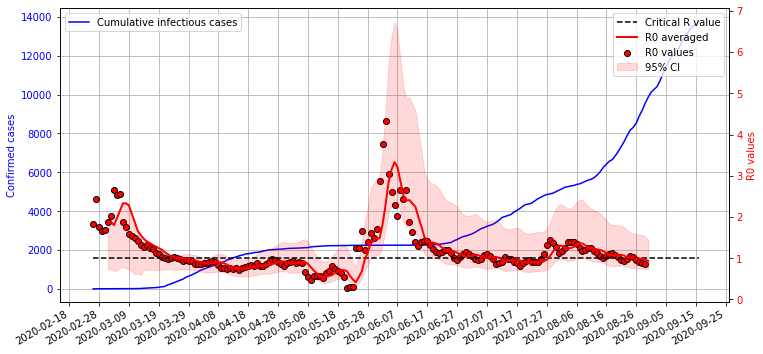

In [3]:
reproduction_rate.run(
    epidemics_start_date,
    confirmed_cases,
    averaging_period,
    symptoms_delay,
    ci_plot=True,
    sensitivity=0.85, specificity=0.95, daily_tests=daily_tests)